# 사전 학습된 CNN(VGG-16)을 이용한 Feature Extraction
## VGG-16 Model
* University of Oxford - Visual Geometry Group
* 2014 ILSVRC 2nd Model
* ImageNet Large Scale Visual Recognition Challenge (ILSVRC)


In [1]:
import warnings
warnings.filterwarnings('ignore')

* Import TensorFlow

In [2]:
import tensorflow as tf

tf.__version__

'2.15.0'

# I. wget From Github
* 'dogs_and_cats_small.zip' 파일 다운로드

In [3]:
!wget https://raw.githubusercontent.com/rusita-ai/pyData/master/dogs_and_cats_small.zip

--2024-01-23 12:50:21--  https://raw.githubusercontent.com/rusita-ai/pyData/master/dogs_and_cats_small.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90618980 (86M) [application/zip]
Saving to: ‘dogs_and_cats_small.zip’

dogs_and_cats_small 100%[===================>]  86.42M  94.2MB/s    in 0.9s    

2024-01-23 12:50:23 (94.2 MB/s) - ‘dogs_and_cats_small.zip’ saved [90618980/90618980]



* 다운로드 결과 확인

In [4]:
!ls -l

total 88500
-rw-r--r-- 1 root root 90618980 Jan 23 12:50 dogs_and_cats_small.zip
drwxr-xr-x 1 root root     4096 Jan 19 14:20 sample_data


# II. Data Preprocessing

> ## 1) Unzip 'dogs_and_cats_small.zip'

In [5]:
!unzip -q /content/dogs_and_cats_small.zip

* 학습 데이터 확인

In [6]:
!ls -l

total 88512
-rw-r--r-- 1 root root 90618980 Jan 23 12:50 dogs_and_cats_small.zip
drwxr-xr-x 1 root root     4096 Jan 19 14:20 sample_data
drwxr-xr-x 4 root root     4096 Jan 23 12:50 test
drwxr-xr-x 4 root root     4096 Jan 23 12:50 train
drwxr-xr-x 4 root root     4096 Jan 23 12:50 validation


> ## 2) Image_File Directory Setting

* train_dir
* valid_dir
* test_dir

In [7]:
train_dir = './train'
valid_dir = './validation'
test_dir = './test'

# III. Import VGG-16 Model
* https://keras.io/api/applications/#usage-examples-for-image-classification-models
* https://keras.io/api/applications/#usage-examples-for-image-classification-models

> ## 1) conv_base

In [10]:
from tensorflow.keras.applications import VGG16
VGG16?

In [9]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet', # 이미지넷 데이터를 학습한 가중치
                  include_top = False, # 네트워크 상단에 FC layer 포함 여부 (출력을 위한 DNN레이어)
                  input_shape = (150, 150, 3)) # 새로 훈련할 catsdogs 데이터셋에 맞춤(VGG모델의 기본 입력크기는 224x224)

58889256/58889256 [==============================] - 0s 0us/step


> ## 2) Model Information

In [11]:
# 깊은 합성곱층을 만들기 위해 output shape를 padding을 통해 유지한다.
# filter를 여러번 거칠 수록 피처맵이 이미지의 전체영역의 특징이 포함된다.
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

# IV. Feature Extraction

> ## 1) 특징추출 함수 정의 : extract_feature( )
* conv_base.predict( )

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

datagen = ImageDataGenerator(rescale = 1./255)

batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape = (sample_count, 4, 4, 512)) # conv_base의 마지막 레이어 output shape에 맞춤
    labels = np.zeros(shape = (sample_count))

    generator = datagen.flow_from_directory(directory,
                                            target_size = (150, 150),
                                            batch_size = batch_size,
                                            class_mode = 'binary')

    # conv_base를 통해 이미지에서 추출한 특징(feature map)을 각 배열에 저장
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch, verbose = 0)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

> ## 2) 특징추출 함수 적용
* train_dir, valid_dir, test_dir

* 약 1분

In [13]:
# %%time

train_features, train_labels = extract_features(train_dir, 2000)
valid_features, valid_labels = extract_features(valid_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [14]:
train_features.shape, valid_features.shape, test_features.shape

((2000, 4, 4, 512), (1000, 4, 4, 512), (1000, 4, 4, 512))

> ## 3) Reshape Features
* For 'Classification' Network

In [15]:
# Fully Connected를 위해 1차원으로 flatten
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
valid_features = np.reshape(valid_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

train_features.shape, valid_features.shape, test_features.shape

((2000, 8192), (1000, 8192), (1000, 8192))

# V. Keras DNN Modeling with VGG-16 Featured Data

> ## 1) Model Define

* 'Classification' Network Only
* Dropout Layer

In [16]:
# 커스텀 FC DNN 생성
from tensorflow.keras import models, layers

model = models.Sequential()
model.add(layers.Dense(256, activation = 'relu', input_dim = 4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 2097665 (8.00 MB)
Trainable params: 2097665 (8.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


> ## 2) Model Compile

* 모델 학습방법 설정

In [18]:
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

> ## 3) Model Fit

* 약 2분

In [19]:
# %%time

Hist_dandc = model.fit(train_features, train_labels,
                       epochs = 100,
                       batch_size = 20,
                       validation_data = (valid_features, valid_labels))

Epoch 1/100
100/100 [==============================] - 4s 8ms/step - loss: 0.4853 - accuracy: 0.7985 - val_loss: 0.3555 - val_accuracy: 0.8370
Epoch 2/100
100/100 [==============================] - 1s 6ms/step - loss: 0.2749 - accuracy: 0.8845 - val_loss: 0.2700 - val_accuracy: 0.8850
Epoch 3/100
100/100 [==============================] - 1s 6ms/step - loss: 0.2006 - accuracy: 0.9225 - val_loss: 0.3371 - val_accuracy: 0.8530
Epoch 4/100
100/100 [==============================] - 1s 6ms/step - loss: 0.1839 - accuracy: 0.9220 - val_loss: 0.2440 - val_accuracy: 0.9030
Epoch 5/100
100/100 [==============================] - 1s 6ms/step - loss: 0.1513 - accuracy: 0.9425 - val_loss: 0.2558 - val_accuracy: 0.8990
Epoch 6/100
100/100 [==============================] - 0s 5ms/step - loss: 0.1506 - accuracy: 0.9375 - val_loss: 0.2805 - val_accuracy: 0.8850
Epoch 7/100
100/100 [==============================] - 0s 5ms/step - loss: 0.1126 - accuracy: 0.9565 - val_loss: 0.2799 - val_accuracy: 0.8920

> ## 4) 학습 결과 시각화

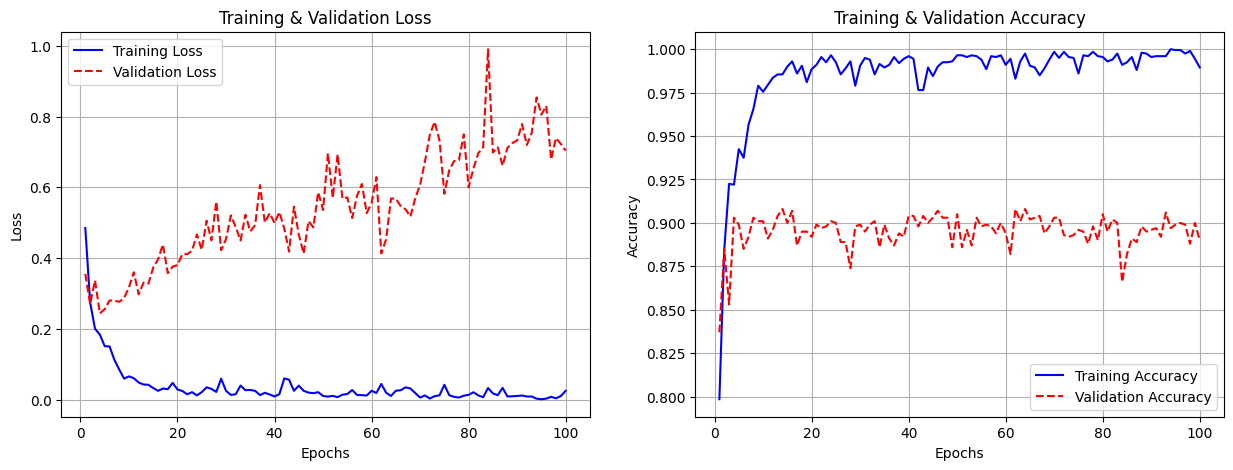

In [20]:
import matplotlib.pyplot as plt

epochs = range(1, len(Hist_dandc.history['loss']) + 1)

plt.figure(figsize = (15, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, Hist_dandc.history['loss'], 'b-')
plt.plot(epochs, Hist_dandc.history['val_loss'], 'r--')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epochs, Hist_dandc.history['accuracy'], 'b-')
plt.plot(epochs, Hist_dandc.history['val_accuracy'], 'r--')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.grid()

plt.show()

> ## 5) Model Evaluate

* Loss & Accuracy

In [21]:
loss, accuracy = model.evaluate(test_features, test_labels, verbose = 0)

print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

Loss = 0.76520
Accuracy = 0.87900


# The End